# Work starting on January 19th: Part 2

1. Just have the defocus (and no aberration) <br>
    a. How does the performance vary with number of iterations? <br>
    b. How does the performance vary with learning rate? <br>
    c. How does the performance vary with loss multiplier? <br>
    d. How does the performance vary with optimizer?
        i. Research what SGD and Adam optimizers are.
        ii. What are the benefits of Adam over SGD? In what cases are which more or less appropriate?
    e. How does the performance vary with different starting values of defocus? <br>
        i. Research what is typical uncertainty in the defocus value.

2. Just take one aberration (spherical aberration) into account. Repeat above steps. <br>
   Also track what happens to the aberration values- should tend towards the GT (0).
   a. Different aberration values- use the best value from this to influence the choice of starting value for future    programs <br>
   b. Number of iterations
   c. Learning rate
   d. Loss multiplier (worth repeating?)

3. Add some noise to the reference image. <br>
    Generate image and add noise using the Demos/HRTEM.py program.

4. Simulate a molecule instead of a crystal. <br>
    
While examining, collect the resultant images.    

While examining, look at the gradients.
The gradient if starting at a defocus of 200 (the ground truth) should be zero.

In [1]:
import pyms
import numpy as np
import torch
import time
from pyms.Probe import aberration
from copy import deepcopy
import matplotlib.pyplot as plt

from pyms.utils.torch_utils import (
    amplitude,
    crop_to_bandwidth_limit_torch,
    size_of_bandwidth_limited_array,
    amplitude,
)

from pyms.Probe import (
    make_contrast_transfer_function,
)

%matplotlib inline

#crystal = pyms.structure.fromfile(
#    "Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
#)

crystal = pyms.structure.fromfile(
    "/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/Demos/Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic structure
crystal = crystal.resize([0.1, 0.76], axis=0)

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# No aperture is also an option
# app = None

# Set up series of thicknesses
thicknesses = np.array([100])


In [2]:
# Establish aberrations
# Introduce one aberration: the spherical aberration

def establish_aberrations():
    """Create a list of aberrations. Initialise with starting values."""

    aberrations = []

    # Initial guesses for aberrations
    df = 175.0
    Cs = 10.0 # this (from 2a) was the best starting value, so we are using this IGNORE THIS COMMENT
    
    # Krivanek aberration coefficient, Haider aberration coefficient, colloquial name, amplitude, angle, n, m
    # n and m are constants (shouldn't be differentiable), amplitude and angle should be

    aberrations.append(aberration("C10", "C1", "Defocus          ", torch.tensor([df], requires_grad = True), 0.0, 1, 0.0))
    aberrations.append(aberration("C30", "C3", "3rd order spher. ", torch.tensor([Cs], requires_grad = True), 0.0, 3, 0.0))
    
    return aberrations


In [3]:
# Set up our initial guess for the crystal HRTEM
# It uses the aberrations (including defocus) as set above

def create_initial_guess(aberrations):

    output = pyms.HRTEM(
        crystal,
        gridshape,
        eV,
        app,
        thicknesses,
        subslices=subslices,
        aberrations=aberrations,
        df= aberrations[0].amplitude,
        tiling=tiling,
        nfph=1,
        showProgress='notebook', 
        apply_ctf = False,
    )
    #plt.imshow(torch.abs(output).detach().cpu().numpy(), vmax = 10)
    
    return output

In [9]:
def save_sim_image(sim_image, n_iter):
    plt.imshow(sim_image[0].detach().cpu().numpy())
    

    plt.title(u'Simulated image of SrTiO\u2083/CeO\u2082 interface\n after {n_iter} iterations'.format(n_iter=n_iter), fontsize=15)
    plt.xticks([])
    plt.yticks([])

    filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_2_multiple_aberrations/Variation_with_iterations/simulated_image_"+ str(n_iter) + ".jpg"
    plt.savefig(filepath, dpi=500)
    print("Saved")

In [10]:
def optimise(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier):
    """Go through and refine the aberrations to minimise difference between initial guess (output) and experimental image"""

    bw_limit_size = size_of_bandwidth_limited_array(gridshape)
    rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

    curves = []
    params = []

    for i in range(0, len(aberrations)):
        params.append(aberrations[i].amplitude)
        curves.append([])

    optimizer = torch.optim.Adam(params, lr = learning_rate)
    criterion = torch.nn.MSELoss()

    loss_curve = []


    start = time.time()

    for iter in range(n_iters):
        ctf = (
                torch.stack(
                    [
                        make_contrast_transfer_function(
                            bw_limit_size, rsize, eV, app, df=aberrations[0].amplitude, aberrations=aberrations
                        )
                    ]
                )
            .type(torch.complex128)
            .to('cpu') # changed cuda to cpu
        )

        sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))

        optimizer.zero_grad()

        loss = criterion(sim_image, ref_data)*loss_multiplier

        loss.backward()

        optimizer.step()

        loss_curve.append(loss.item())


        for i in range(0,len(curves)):
            curves[i].append(aberrations[i].amplitude.item())


    end = time.time()
    
    runtime = end-start
    
    save_sim_image(sim_image, n_iters)
    
    return runtime, loss.item(), aberrations[0].amplitude.item(), aberrations[1].amplitude.item()

In [11]:
def main(n_iters, learning_rate, loss_multiplier):
    aberrations = establish_aberrations()
    output = create_initial_guess(aberrations)
    
    # Load in "experimental" data
    path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'
    ref_data = np.load(path)
    ref_data = torch.tensor(ref_data).to('cpu')
    
    runtime, loss, defocus_final, ab_final = optimise(aberrations, output, ref_data, n_iters, learning_rate, loss_multiplier)
    return runtime, loss, defocus_final, ab_final
    

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

2


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Saved


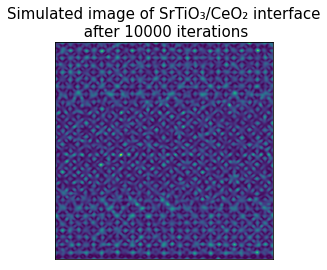

In [12]:
n_iters = [10, 100, 500, 1000, 2000, 5000, 10000]

# Constants
loss_multiplier = 1e9
learning_rate = 1e-1

runtimes = []
losses = []
defocus_values = []
ab_values = []

for i in n_iters:
    runtime, loss, defocus_final, ab_final = main(i, learning_rate, loss_multiplier)
    runtimes.append(runtime)
    losses.append(loss)
    defocus_values.append(defocus_final)
    ab_values.append(ab_final)


In [11]:
# Saving data to file code

filename = "Variation_iterations_2.txt"

f = open(filename, "w")
x = "Number of iterations, Loss, Final defocus value, Final Cs value, time to run"
f.write(x)
f.write("\n")

for i in range(0, len(lrs)):
    line = str(n_iters[i]) +  ", " + str(losses[i]) + ", " + str(defocus_values[i]) + ", " + ", " + str(ab_values[i]) + str(runtimes[i])
    f.write(line)
    f.write("\n")

f.close() 

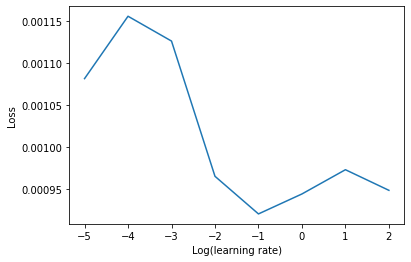

In [17]:
import math

plt.plot(n_iters, losses)
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_2_multiple_aberrations/Variation_with_iterations/Loss.jpg"
plt.savefig(filepath, dpi=500)

plt.show()

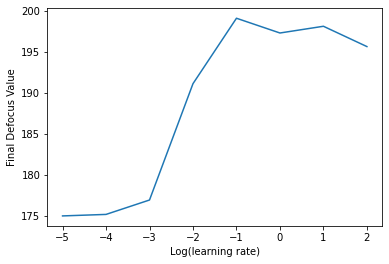

In [18]:
plt.plot(n_iters, defocus_values)
plt.ylabel('Final Defocus Value')
plt.xlabel('Number of iterations')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_2_multiple_aberrations/Variation_with_iterations/Defocus.jpg"
plt.savefig(filepath, dpi=500)

plt.show()

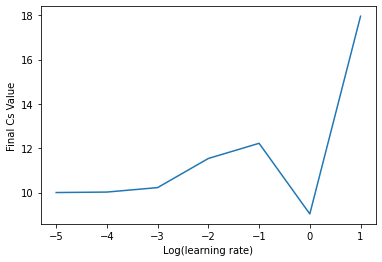

In [23]:
plt.plot(n_iters, ab_values)
plt.ylabel('Final Cs Value')
plt.xlabel('Number of iterations')

filepath = "/home/hremadmin/Documents/Project/ML_files/Work_Jan_19/Part_2_multiple_aberrations/Variation_with_iterations/Aberration.jpg"
plt.savefig(filepath, dpi=500)

plt.show()